In [1]:
##导入包
import pandas as pd
import numpy as np
import scipy.stats as st
import matplotlib.pyplot as plt
import statsmodels.stats.anova as sma
import statsmodels.formula.api as smf
import statsmodels.stats.api as smt
import statsmodels.api as sm
from statsmodels.graphics.mosaicplot import mosaic
import seaborn as sns
plt.rcParams['font.sans-serif'] = ['SimHei']  # 用来正常显示中文标签
plt.rcParams['axes.unicode_minus'] = False  # 用来正常显示负号

###  对数线性模型
- #### 资料来源
使用Statsmodels的广义线性回归（GLM，泊松分布族，log连接函数）实现。具体内容参考：《非参数统计》第2版 第5.7节，王星、褚挺进。清华大学出版社 。<br>
列联表数据的分析以及对数线性模型，可以参看经典教材《属性数据分析引论》第7章，Alan Agresti著，高等教育出版社
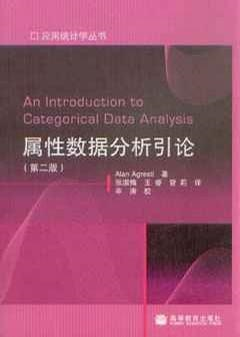
- #### 功能

列联表以假设检验为主要研究方法，只能反应事件的相对频率，不能反应事件的相对强度。对数线性模型(Log-linear model)则可进行参数估计和检验，特别是变量的取值之间有无关联、关联强度的测量等。

- #### 模型估计和检验
常用的统计量有两个：$Pearson$ $\chi^2$和对数似然比


- #### 三维列联表独立类型及其检验
独立类型：
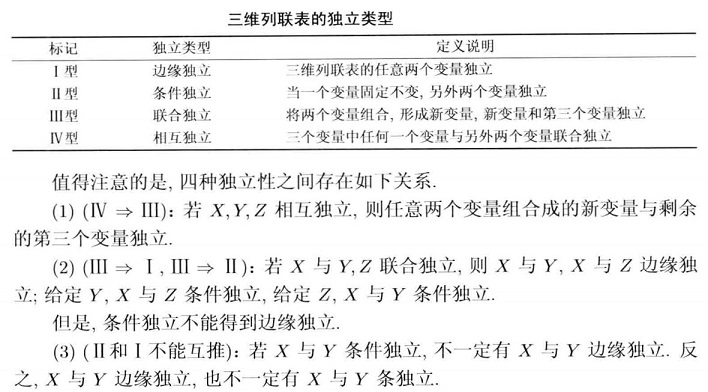
独立性检验：
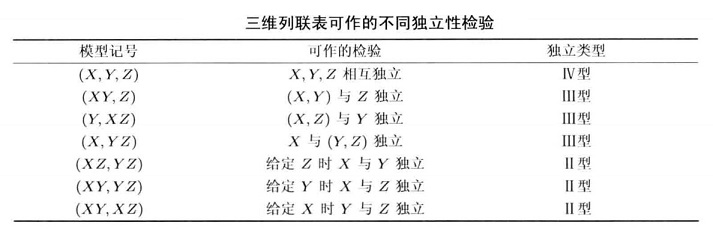

- #### 示例：
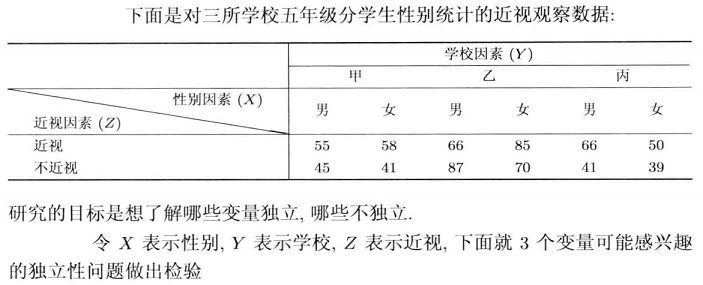


In [2]:
'''
对数线性模型
可以将三维列联表进行因子化，转换成plain数据，便于操作。
'''
###单元频数
count1=np.array([55,58,66,85,66,50,45,41,87,70,41,39],dtype='int')
### 近视因素，对近视与非近视进行因子化
f_myopia=np.array(['Y', 'Y', 'Y', 'Y', 'Y', 'Y', 'N', 'N', 'N', 'N', 'N', 'N'])
###性别因素的因子化，M：男性，F：女性
f_gender=np.array(['M','F','M','F','M','F','M','F','M','F','M','F'])
###学校因素：甲、乙、丙
f_school=np.array(['A','A','B','B','C','C','A','A','B','B','C','C'])
#data=np.vstack([f_myopia ,f_gender ,f_school])
dic1={'count1':count1,'myopia':f_myopia,'gender':f_gender,'school':f_school}
###将数据（除单元频数外）放入一个DataFrame
d_dataframe=pd.DataFrame(dic1)

In [3]:
'''
（1）7种独立检验记号及其模型公式。
（2）使用count即单元频数作为因变量，然后根据独立检验类型构造自变量。
比如如果检验近视、性别和学校是否各自两两独立，即(X,Y,Z)检验类型，
通过C(gender,Sum)+C(school,Sum)+C(myopia,Sum)将近视、性别和学校三个因素转化成哑变量，
通过‘+’号连接。
（3）如若考察X与(Y,Z)的联合是否独立，则将C(school,Sum)*C(myopia,Sum)，
即使用‘*’号连接因素然后再与X通过‘+’号连接，即：C(gender,Sum)+C(school,Sum)*C(myopia,Sum)。
（4）其他公式依此类推。
'''
###(X,Y,Z)
formula1='count1 ~ C(gender)+C(school)+C(myopia)'
###(XY,Z)
formula2='count1 ~ C(myopia)+C(gender)*C(school)'
###(X,YZ)
formula3='count1 ~ C(gender)+C(school)*C(myopia)'
###(Y,XZ)
formula4='count1 ~ C(school)+C(myopia)*C(gender)'
###(XY,XZ)
formula5='count1 ~ C(gender)*C(school)+C(gender)*C(myopia)'
###(XY,YZ)
formula6='count1 ~ C(gender)*C(school)+C(school)*C(myopia)'
###(XZ,YZ)
formula7='count1 ~ C(gender)*C(myopia)+C(school)*C(myopia)'

###模型与公式
models=np.array(['(X, Y, Z)','(XY, Z)','(X, YZ)','(Y, XZ)','(XY, XZ)','(XY, YZ)','(XZ, YZ)'])
formulas=np.array([formula1,formula2,formula3,formula4,formula5,formula6,formula7])

In [4]:
df=[]#自由度
LRT=[]#对数似然比
LRT_p=[]#对似然比的p值
PQ=[]#Pearson Q值
PQ_p=[]#Pearson Q值的p值
conclusions=[]#独立与否的结论

###对上述7个模型的公式分别调用glm，广义线性模型（泊松分布族和log连接函数）
#Poisson()类构造器默认使用log连接函数
for formula in formulas:
    result=smf.glm(formula,data=d_dataframe,
                   family=sm.families.Poisson()).fit(use_t=True)
    LRT.append(np.round(result.deviance,6))#对数似然比=回归结果的偏差
    PQ.append(np.round(result.pearson_chi2,6))#Pearson Q等于结果中的Pearson卡方值
    #对数似然比的卡方检验p值
    LRT_p.append(np.round(st.chi2.sf(result.deviance,result.df_resid),8))
    df.append(result.df_resid)#自由度
    #Pearson Q统计量的卡方检验的p值
    q_p=st.chi2.sf(result.pearson_chi2,result.df_resid)
    
    ###根据Pearson Q统计量的卡方检验的p值判定是否独立。
    #设alpha=0.1，相对宽松的置信度。
    #也可以使用对数似然比的卡方检验p值判定是否独立。
    if q_p>=0.1:
        conclusions.append('独立')
    else:
        conclusions.append('不独立')
    PQ_p.append(np.round(q_p,8))

dic_data={'模型':models,'自由度':df,'LRT G2':LRT,'p值1':LRT_p,
          'Pearson Q':PQ,'p值2':PQ_p,'结论':conclusions}
goodness=pd.DataFrame(dic_data)
goodness

,模型,自由度,LRT G2,p值1,Pearson Q,p值2,结论
0,"(X, Y, Z)",7,12.174808,0.094955,12.115692,0.096818,不独立
1,"(XY, Z)",5,10.912539,0.053142,10.903892,0.053319,不独立
2,"(X, YZ)",5,6.360043,0.272744,6.346698,0.273930,独立
3,"(Y, XZ)",6,10.852045,0.093058,10.926133,0.090686,不独立
4,"(XY, XZ)",4,9.589775,0.047935,9.538042,0.048971,不独立
5,"(XY, YZ)",3,5.097773,0.164776,5.088329,0.165442,独立
6,"(XZ, YZ)",4,5.037279,0.283494,5.024954,0.284747,独立
